In [112]:
# noise vocoded speech

from __future__ import division, print_function
import numpy as np
from numpy import (arange, pi, zeros)
import scipy as sp
from scipy.io import wavfile
import scipy.signal
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, Audio
import librosa
plt.style.use('bmh')
%matplotlib inline


In [168]:
fs, cheese = wavfile.read('LJ001-0001.wav')
cheese = cheese.astype('float')
cheese = librosa.resample(cheese,fs,16000)

print('sampling frequency is {}'.format(fs))
fs = 16000

sampling frequency is 22050


In [169]:
Audio(data=cheese, rate=fs)


In [170]:
# 定义一个 plot figure 方便一点
def plot_signal(x, fs):
    n = x.shape[-1]
    time = np.arange(n) / fs
    plt.plot(time, x,alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    


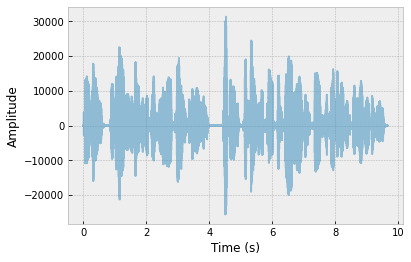

In [171]:
plot_signal(cheese, fs)


In [172]:
def third_octave_bounds(cf):
    third_octave_ratio = 2 ** (1/6)  # 2 * 1/6 = 1/3
    return np.array([cf / third_octave_ratio, cf * third_octave_ratio])


In [173]:
bounds = third_octave_bounds(1000)
'{:.2f} and {:.2f} Hz'.format(*bounds)


'890.90 and 1122.46 Hz'

In [174]:
def design_filter(bounds, fs):
    return sp.signal.butter(4, bounds * 2 / fs, btype='bandpass')


In [175]:
from scipy.signal import lfilter

def bandpass_filter(x, cf, fs):
    bounds = third_octave_bounds(cf)
    num, den = design_filter(bounds, fs)
    return lfilter(num, den, x)


In [176]:
# 滤波器 后的结果
y = bandpass_filter(cheese, 1000, fs)
Audio(y, rate=fs)


# The speech now sounds "narrow" and quieter.

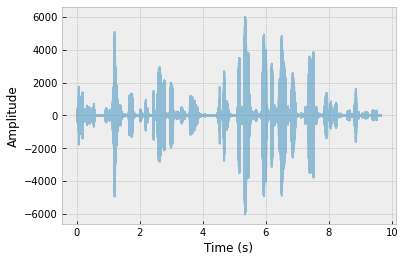

In [177]:
plot_signal(y, fs)

In [178]:
from IPython.html.widgets import interact, fixed
from IPython.display import display

def audio_bandpass_filtered_signal(x, cf, fs):
    y = bandpass_filter(x, cf, fs)
    display(Audio(y, rate=fs))


In [179]:
interact(audio_bandpass_filtered_signal, cf=(100, 6000, 500), x=fixed(cheese), fs=fixed(fs))


interactive(children=(IntSlider(value=2600, description='cf', max=6000, min=100, step=500), Output()), _dom_cl…

<function __main__.audio_bandpass_filtered_signal(x, cf, fs)>

In [180]:
def octave_spaced_frequencies(low, high):
    number_of_octaves = np.log2(high) - np.log2(low)
    return low * 2 ** arange(number_of_octaves)


In [181]:
octave_spaced_frequencies(100, 1000)

array([100., 200., 400., 800.])

In [182]:
def design_filterbank(center_frequencies, fs):
    boundaries = [third_octave_bounds(cf) for cf in center_frequencies]
    return [design_filter(bounds, fs) for bounds in boundaries]


In [183]:
center_frequencies = octave_spaced_frequencies(100, 201)
design_filterbank(center_frequencies, fs)

[(array([ 4.22328822e-10,  0.00000000e+00, -1.68931529e-09,  0.00000000e+00,
          2.53397293e-09,  0.00000000e+00, -1.68931529e-09,  0.00000000e+00,
          4.22328822e-10]),
  array([  1.        ,  -7.97008822,  27.79717258, -55.41104193,
          69.05072424, -55.08284116,  27.46886141,  -7.82930454,
           0.97651762])),
 (array([ 6.67800184e-09,  0.00000000e+00, -2.67120074e-08,  0.00000000e+00,
          4.00680110e-08,  0.00000000e+00, -2.67120074e-08,  0.00000000e+00,
          6.67800184e-09]),
  array([  1.        ,  -7.92796005,  27.52245933, -54.64623661,
          67.87314748, -54.00080055,  26.87615485,  -7.65035058,
           0.95358612]))]

In [184]:
def apply_filterbank(x, center_frequencies, fs):
    n_samples = x.shape[-1]
    n_channels = len(center_frequencies)
    
    coefficients = design_filterbank(center_frequencies, fs)
    y = zeros((n_channels, n_samples))
    for idx, (b, a) in enumerate(coefficients):
        y[idx] = lfilter(b, a, x)
    return y

In [185]:
center_frequencies = octave_spaced_frequencies(100, 1000)
y = apply_filterbank(cheese, center_frequencies, fs)
channel_index = 1
print('Channel centered at {} Hz'.format(center_frequencies[channel_index]))
Audio(y[channel_index], rate=fs)


Channel centered at 200.0 Hz


In [186]:
print(y.shape)
y = np.sum(y, axis=0)
print(y.shape)

(4, 154481)
(154481,)


In [187]:
Audio(y, rate=fs)

In [188]:
def compare_spectrogram(x, y, fs):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

    p_x, *_, im  = axes[0].specgram(x, cmap='Blues', Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap='Blues', Fs=fs, vmin=vmin, vmax=vmax)
    axes[0].set_title('Original')
    axes[1].set_title('Modified')
    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.grid(False)
    axes[0].set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(im)
    cbar.ax.set_ylabel('Magnitude (dB)')
    fig.tight_layout()


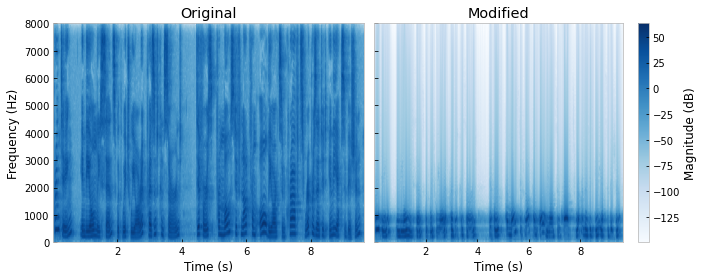

In [189]:
compare_spectrogram(cheese, y, fs)

In [190]:
highest_cutoff = third_octave_bounds(center_frequencies[-1])[-1]
'Highest cutoff frequency: {:.2f} Hz'.format(highest_cutoff)


'Highest cutoff frequency: 897.97 Hz'

As mentioned in the introduction, one of the goals of the vocoder design was to reduce the amount of information that had to be transmitted. In order to do so, the vocoder extracts the envelope of the signal, which means the shape of the slow fluctuations in the signal.



In [191]:
def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

# 提取低频震荡的 两种手法 应该是 
# 1 20hz的低筒滤波
# 2 那个技术的 

In [192]:
envelope = extract_envelope(cheese)
print(envelope.shape)

(154481,)


In [193]:
def plot_signal_and_envelope(x, envelope, fs):
    fig, ax = plt.subplots()
    t = arange(x.shape[-1]) / fs
    ax.plot(t, x, label='signal')
    ax.plot(t, envelope, label='envelope')
    ax.legend(loc='best')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')    


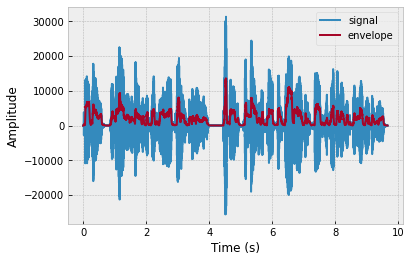

In [194]:
plot_signal_and_envelope(cheese, envelope, fs)

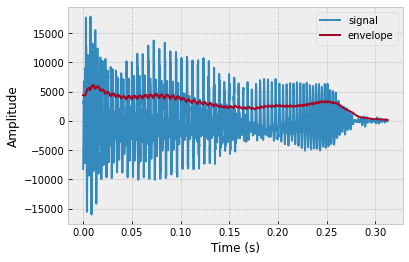

In [195]:
section = slice(5000, 10000)
plot_signal_and_envelope(cheese[section], envelope[section], fs)


In [196]:
def plot_cutoff_frequency_effect(cutoff):
    envelope = extract_envelope(cheese, cutoff=cutoff)
    plot_signal_and_envelope(cheese, envelope, fs)


In [197]:
interact(plot_cutoff_frequency_effect, cutoff=(1, 101, 5))


interactive(children=(IntSlider(value=51, description='cutoff', max=101, min=1, step=5), Output()), _dom_class…

<function __main__.plot_cutoff_frequency_effect(cutoff)>

In [198]:
# noise level how to control
noise = np.random.randn(*cheese.shape)

# 白噪声 特定区域？？ 


In [199]:
envelope = extract_envelope(cheese)
vocoded_noise = envelope * noise
Audio(data=vocoded_noise, rate=fs)


In [200]:
def vocode(x, center_frequencies, fs):
    n_channels = len(center_frequencies)
    n_samples = x.shape[-1]
    noise = np.random.randn(n_samples) 

    filtered_x = apply_filterbank(x, center_frequencies, fs)
    filtered_noise = apply_filterbank(noise, center_frequencies, fs)
    
    vocoded_noise = np.zeros((n_channels, n_samples))
    for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
        envelope = extract_envelope(x_band)
        vocoded_noise[idx] = envelope * noise_band
    return np.sum(vocoded_noise, axis=0)


In [271]:
center_frequencies = octave_spaced_frequencies(100, 6000)
vocoded_cheese = vocode(cheese, center_frequencies, fs)
print('Vocoded speech with bands: {} Hz.'.format(center_frequencies))
Audio(vocoded_cheese, rate=fs)


(6, 39629)
Vocoded speech with bands: [ 100.  200.  400.  800. 1600. 3200.] Hz.


<ipython-input-214-c38059f4be84>:7: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=6).
  _ = axes[1].specgram(y, cmap='Blues', Fs=fs, vmin=vmin, vmax=vmax)


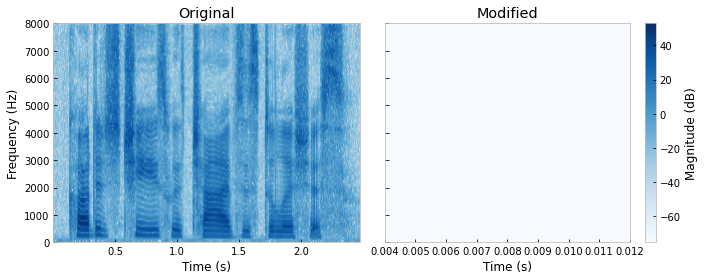

In [274]:
compare_spectrogram(cheese, vocoded_cheese, fs)

In [205]:
from collections import OrderedDict
from IPython.html.widgets import Checkbox


def create_cf_checkboxed(center_frequencies):
    center_frequency_checkboxes = {}
    for cf in center_frequencies:
        cf_string = '{}'.format(cf)
        center_frequency_checkboxes[cf_string] = Checkbox(True, description=cf_string)
    return center_frequency_checkboxes

def combine_center_frequencies(**kwargs):
    center_frequencies = np.array([float(cf) for cf, state in kwargs.items() if state])
    vocoded_cheese = vocode(cheese, center_frequencies, fs)
    cf_strings = ['{:.0f}'.format(cf) for cf in sorted(center_frequencies)]
    cf_string = ', '.join(cf_strings)
    compare_spectrogram(cheese, vocoded_cheese, fs)
    print('Speech vocoded with bands: {} Hz.'.format(cf_string))
    display(Audio(vocoded_cheese, rate=fs))


In [206]:
center_frequencies = octave_spaced_frequencies(100, 6001)
center_frequency_checkboxes = create_cf_checkboxed(center_frequencies)
interact(combine_center_frequencies, **center_frequency_checkboxes)


interactive(children=(Checkbox(value=True, description='100.0'), Checkbox(value=True, description='200.0'), Ch…

<function __main__.combine_center_frequencies(**kwargs)>

In [150]:
# 已经完成了 noise vocoded 

# 尝试 mosaic speech 

# 第一步 滤波 
# try : gamma tone filterbank 
# try : octave filterbank

# 第二步 取包络，增加白噪音 / 加在包络上 

# 第三步 取包络 获取 平均

# 第四步 包络 切成 80ms 每段
## 通过用相同平均强度的带状噪声部分取代每个临界带的每个时间段。.
# 需要 每段一个 平均 替代成 原来的 amplitude-modulated signal
# perfect 
#

In [207]:
# noise vocoded speech

from __future__ import division, print_function
import numpy as np
from numpy import (arange, pi, zeros)
import scipy as sp
from scipy.io import wavfile
import scipy.signal
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, Audio
import librosa
plt.style.use('bmh')
%matplotlib inline


In [208]:
fs, cheese = wavfile.read('audio.wav')
cheese = cheese.astype('float')

print('sampling frequency is {}'.format(fs))

sampling frequency is 16000


In [209]:
def third_octave_bounds(cf):
    third_octave_ratio = 2 ** (1/6)  # 2 * 1/6 = 1/3
    return np.array([cf / third_octave_ratio, cf * third_octave_ratio])


In [210]:
from scipy.signal import lfilter

def design_filter(bounds, fs):
    return sp.signal.butter(4, bounds * 2 / fs, btype='bandpass')
def octave_spaced_frequencies(low, high):
    number_of_octaves = np.log2(high) - np.log2(low)
    return low * 2 ** arange(number_of_octaves)
def design_filterbank(center_frequencies, fs):
    boundaries = [third_octave_bounds(cf) for cf in center_frequencies]
    return [design_filter(bounds, fs) for bounds in boundaries]
def apply_filterbank(x, center_frequencies, fs):
    n_samples = x.shape[-1]
    n_channels = len(center_frequencies)
    
    coefficients = design_filterbank(center_frequencies, fs)
    y = zeros((n_channels, n_samples))
    for idx, (b, a) in enumerate(coefficients):
        y[idx] = lfilter(b, a, x)
    return y

In [211]:
center_frequencies = octave_spaced_frequencies(100, 1000)
y = apply_filterbank(cheese, center_frequencies, fs)
channel_index = 1
print('Channel centered at {} Hz'.format(center_frequencies[channel_index]))
Audio(y[channel_index], rate=fs)


Channel centered at 200.0 Hz


In [212]:
center_frequencies = octave_spaced_frequencies(100, 7000)
y = apply_filterbank(cheese, center_frequencies, fs)
channel_index = 1
print('Channel centered at {} Hz'.format(center_frequencies[channel_index]))
Audio(y[channel_index], rate=fs)


Channel centered at 200.0 Hz


In [213]:
# 滤波七个段 
y.shape

(7, 39629)

In [214]:
def compare_spectrogram(x, y, fs):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

    p_x, *_, im  = axes[0].specgram(x, cmap='Blues', Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap='Blues', Fs=fs, vmin=vmin, vmax=vmax)
    axes[0].set_title('Original')
    axes[1].set_title('Modified')
    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.grid(False)
    axes[0].set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(im)
    cbar.ax.set_ylabel('Magnitude (dB)')
    fig.tight_layout()

In [215]:
def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

# 提取低频震荡的 两种手法 应该是 
# 1 20hz的低筒滤波
# 2 那个技术的 

In [216]:
# 低通滤波 获取包络 


In [217]:
noise = np.random.randn(*cheese.shape)
noise.shape

(39629,)

In [218]:
def vocode(x, center_frequencies, fs):
    n_channels = len(center_frequencies)
    # 几个滤波器 
    n_samples = x.shape[-1]
    # 获取sample的数量
    noise = np.random.randn(n_samples) 
    # 生成白噪音 
    
    filtered_x = apply_filterbank(x, center_frequencies, fs)
    
    filtered_noise = apply_filterbank(noise, center_frequencies, fs)
    
    vocoded_noise = np.zeros((n_channels, n_samples))
    # 获取 noise 
    
    for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
        envelope = extract_envelope(x_band)
        vocoded_noise[idx] = envelope * noise_band
    #return np.sum(vocoded_noise, axis=0)
    print(vocoded_noise.shape)
    return vocoded_noise


In [219]:
center_frequencies = octave_spaced_frequencies(100, 7000)
vocoded_cheese = vocode(cheese, center_frequencies, fs)
print('Vocoded speech with bands: {} Hz.'.format(center_frequencies))
Audio(vocoded_cheese, rate=fs)


(7, 39629)
Vocoded speech with bands: [ 100.  200.  400.  800. 1600. 3200. 6400.] Hz.


In [251]:
# noise vocoded done 

In [223]:
x = vocoded_cheese[0]

duration = 40
# ms 

sample_points = int(duration/1000*fs)

to_pad = round(len(x)/sample_points) * sample_points

length = abs(len(x) - to_pad)

x_padded = np.pad(x, (0, length), 'constant', constant_values=(0, 0))

x_seg = x_padded.reshape(round(len(x)/sample_points),sample_points)

In [226]:
x_seg.shape
# 62 段 每一段有 40 ms 总计 2480ms 

(62, 640)

In [232]:
x_seg[0].mean()

# 全部替换为 mean

x_seg[0] = [ x_seg[0].mean() for i in x_seg[0]]

In [236]:
x_seg.shape[0]

62

In [241]:
for j in range(x_seg.shape[0]):
    x_seg[j] = [ x_seg[j].mean() for i in x_seg[j]]
    
# 全部替换为了

In [246]:
mean_s = x_seg.flatten()

In [ ]:
mean_s

In [247]:
Audio(mean_s, rate=fs)

# 补0操作 前面补0个 后面补 length的长度

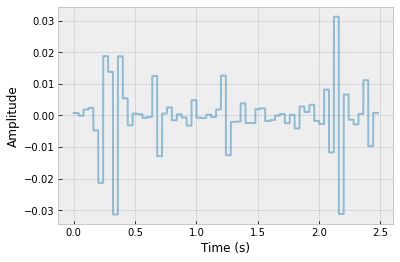

In [248]:
plot_signal(mean_s, fs)

In [255]:
plane = np.zeros((7, 39680))

In [256]:
# all in one 


for w in range(vocoded_cheese.shape[0]):
    
    x = vocoded_cheese[w]

    duration = 40
    # ms 

    sample_points = int(duration/1000*fs)

    to_pad = round(len(x)/sample_points) * sample_points

    length = abs(len(x) - to_pad)

    x_padded = np.pad(x, (0, length), 'constant', constant_values=(0, 0))

    x_seg = x_padded.reshape(round(len(x)/sample_points),sample_points)

    for j in range(x_seg.shape[0]):
        x_seg[j] = [ x_seg[j].mean() for i in x_seg[j]]
    mean_s = x_seg.flatten()
    plane[w] = mean_s

In [ ]:
def plot_spectrogram(x, y, fs):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

    p_x, *_, im  = axes[0].specgram(x, cmap='Blues', Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap='Blues', Fs=fs, vmin=vmin, vmax=vmax)


In [375]:
def vocode(x, center_frequencies, fs):
    n_channels = len(center_frequencies)
    # 几个滤波器 
    n_samples = x.shape[-1]
    
    # 获取sample的数量
    noise = np.random.randn(n_samples) 
    
    # 生成白噪音 
    
    filtered_x = apply_filterbank(x, center_frequencies, fs)
    filtered_noise = apply_filterbank(noise, center_frequencies, fs)
    
    # 分段 获取 padding 后的长度 
    filtered_x_seg,leg = reshape(40,filtered_x)
    filtered_noise_seg,leg = reshape(40,filtered_noise)
    
    print(filtered_x_seg.shape,filtered_noise_seg.shape)
    
    # 修改一下 plane 的 大小 
    vocoded_noise = np.zeros((n_channels, leg))

    # 获取 noise plant
    for idx, (x_band, noise_band) in enumerate(zip(norm_x, norm_noise)):
        envelope = extract_envelope(x_band)
        vocoded_noise[idx] = envelope * noise_band
        
    # 模糊化
    norm_x = normalized_all(filtered_x_seg)
    norm_noise = normalized_all(filtered_noise_seg)
    print(norm_x.shape,norm_noise.shape)
    
    #return np.sum(vocoded_noise, axis=0)    
    return vocoded_noise


In [554]:
# work one 

center_frequencies = octave_spaced_frequencies(100, 7000)

n_channels = len(center_frequencies)
# 几个滤波器 
n_samples = x.shape[-1]
# 获取sample的数量
noise = np.random.randn(n_samples) 
# 生成白噪音 

filtered_x = apply_filterbank(x, center_frequencies, fs)
filtered_noise = apply_filterbank(noise, center_frequencies, fs)

vocoded_noise = np.zeros((n_channels, leg))

# 获取 noise plant
envelope_all = np.zeros((n_channels, n_samples))
for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
    envelope = extract_envelope(x_band)
    # reshape & normalization 
    envelope_all[idx] = envelope
    
filtered_x_seg,filtered_x_all, leg = reshape(40,envelope_all)

norm_x = normalized_all(filtered_x_seg)

filtered_noise_seg,filtered_noise_all, leg = reshape(40,filtered_noise)

# 分段 获取 padding 后的长度 噪音应该不能 normalization 我觉得 
# filtered_noise_seg,leg = reshape(40,filtered_noise)
# norm_noise = normalized_all(filtered_noise_seg)

for idx, (x_band, noise_band) in enumerate(zip(norm_x, filtered_noise_all)):
    # x_band = 归一化后的 包络
    # noise 归一化后的 噪音
    vocoded_noise[idx] = x_band * noise_band

In [555]:
final = np.sum(vocoded_noise, axis=0)    

In [556]:
print('Vocoded speech with bands: {} Hz.'.format(center_frequencies))
Audio(final, rate=fs)

Vocoded speech with bands: [ 100.  200.  400.  800. 1600. 3200. 6400.] Hz.


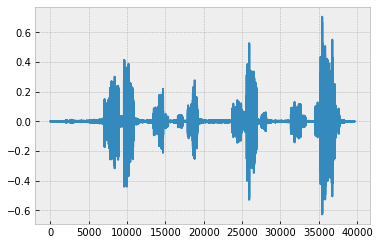

In [553]:
#plt.plot(filtered_x_all[1])
#plt.plot(norm_x[1])
#plt.plot(filtered_noise_all[1])

#plt.plot(norm_x[5] * filtered_noise_all[5])

In [537]:
#compare_spectrogram(cheese,final,fs)
#plot_signal(final,fs)
#plot_signal(cheese,fs)

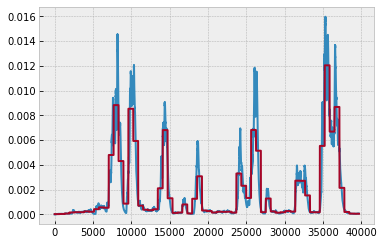

In [479]:
plt.plot(envelope_all[3])
plt.plot(norm_x[3])

In [506]:
# (7, 39629)
def reshape(duration,signal):  
    duration = duration
    #ms
    sample_points = int(duration/1000*fs)

    to_pad = round(len(x)/sample_points) * sample_points

    length = abs(len(x) - to_pad)

    x_padded = np.pad(signal, ((0, 0), (0, length)),constant_values=(0, 0))
    
    x_seg = x_padded.reshape(7, round(len(x)/sample_points),sample_points)
    
    return x_seg, x_padded, to_pad

In [530]:
def normalized_all(filtered_s):
    plane_all = np.zeros((7, filtered_s.shape[-1]*filtered_s.shape[-2]))
    temp = filtered_s
    for i in range(temp.shape[0]):
        x_signal = temp[i]
        plane = np.zeros((62, 640))
        for j in range(x_signal.shape[0]):
            tp = [(x_signal[j].mean()) for i in x_signal[j]]
            plane[j] = tp
            mean_s = plane.flatten()
        plane_all[i] = mean_s
    return plane_all

In [538]:
def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

# 提取低频震荡的 两种手法 应该是 
# 1 20hz的低筒滤波
# 2 那个技术的 

In [ ]:
plane_all = np.zeros((7, filtered_x_seg.shape[-1]*filtered_x_seg.shape[-2]))
temp = filtered_x_seg
for i in range(temp.shape[0]):
    x_signal = temp[i]
    plane = np.zeros((62, 640))
    for j in range(x_signal.shape[0]):
        tp = [abs(x_signal[j].mean()) for i in x_signal[j]]
        plane[j] = tp
        mean_s = plane.flatten()
    plane_all[i] = mean_s


In [316]:
center_frequencies = octave_spaced_frequencies(100, 7000)
vocoded_cheese = vocode(cheese, center_frequencies, fs)
print('Vocoded speech with bands: {} Hz.'.format(center_frequencies))
Audio(vocoded_cheese, rate=fs)


(7, 62, 640) (7, 62, 640)
(7, 39629)
Vocoded speech with bands: [ 100.  200.  400.  800. 1600. 3200. 6400.] Hz.


In [312]:
# 多维度 补0 的操作
qq = np.pad(vocoded_cheese, ((0, 0), (0, length)),constant_values=(0, 0))

In [366]:
# (7, 39629)

def reshape(duration,signal):  
    duration = duration
    #ms
    sample_points = int(duration/1000*fs)

    to_pad = round(len(x)/sample_points) * sample_points

    length = abs(len(x) - to_pad)

    x_padded = np.pad(vocoded_cheese, ((0, 0), (0, length)),constant_values=(0, 0))

    x_seg = x_padded.reshape(7, round(len(x)/sample_points),sample_points)
    
    return x_seg, to_pad